# 1. Setup Mario

In [1]:
%pip install gym_super_mario_bros==7.4.0

  Using cached gym_super_mario_bros-7.4.0-py3-none-any.whl (199 kB)
  Using cached nes_py-8.2.1.tar.gz (77 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-win_amd64.whl size=45830 sha256=338f5a81f3e32e3a242ac056932203e75f618d7469bb4eb39368d2bdfbd3f321
  Stored in directory: c:\users\zengt\appdata\local\pip\cache\wheels\bc\1a\6e\27afc1393514b773012ff8d89f77ed4fa02055aa36f39d43df
Successfully built nes-py
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
#env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb_array', apply_api_compatibility=True)

env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [10]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(100000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, done , info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

d:\Users\zengt\AppData\Local\Programs\Python\Python310\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


# 2. Preprocess Environment

In [8]:
# Install pytorch
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [9]:
# Install stable baselines for RL stuff
!pip install stable-baselines3[extra]

In [3]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

d:\Users\zengt\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [5]:
state = env.reset()

In [6]:
state, reward, done, info = env.step([5])

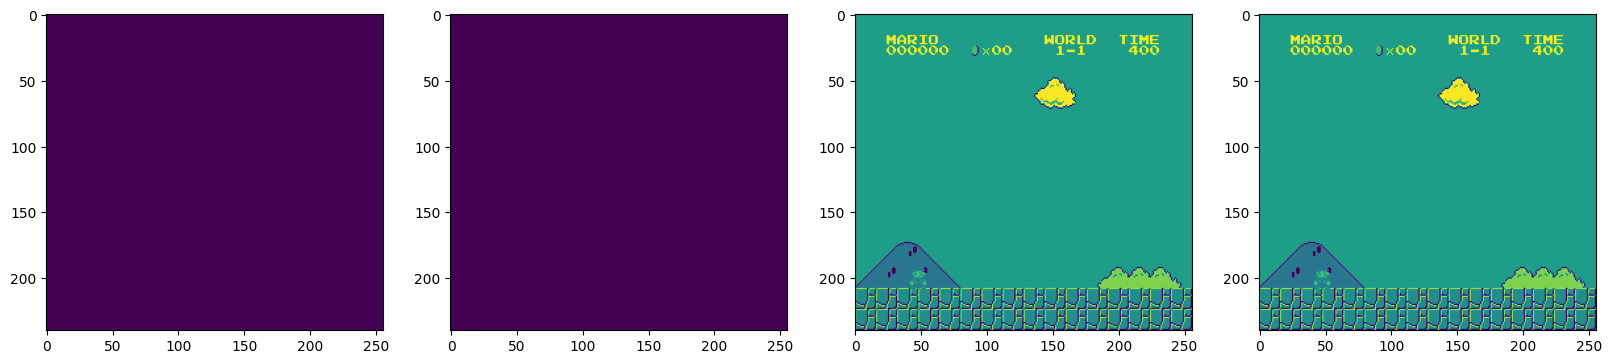

In [7]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [38]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3 import SAC
from stable_baselines3 import A2C
from stable_baselines3 import HerReplayBuffer
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [9]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [10]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [11]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [39]:
# This is the AI model started
#model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
#            n_steps=512, device='cuda') 

#model = DQN('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
#            train_freq =5, device='cuda', optimize_memory_usage=True, replay_buffer_class = HerReplayBuffer,
#                replay_buffer_kwargs=dict(
#        n_sampled_goal=4,
#        goal_selection_strategy = GoalSelectionStrategy,
#        online_sampling=True,
#        max_episode_length=5,
#    )) 

model = A2C("MlpPolicy", env, verbose = 1)




Using cpu device
Wrapping the env in a VecTransposeImage.


In [40]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

------------------------------------
| time/                 |          |
|    fps                | 19       |
|    iterations         | 100      |
|    time_elapsed       | 25       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.483   |
|    value_loss         | 0.0702   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 19       |
|    iterations         | 200      |
|    time_elapsed       | 52       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.8     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.0343   |
|    value_loss         | 0.000441 |
-

KeyboardInterrupt: 

In [20]:
model.save('thisisatestmodel')

# 4. Test it Out

In [21]:
# Load model
model = PPO.load('./train/best_model_220000')

In [22]:
state = env.reset()

In [23]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

d:\Users\zengt\AppData\Local\Programs\Python\Python310\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


KeyboardInterrupt: 

: 